<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 302</h1>
<h1>Age structure</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

from EpiModel import *

import os

import tqdm as tq
from tqdm.notebook import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by printing out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.10.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.0.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 4380650bd787a6c92b2a4a032a94bc11fe3fae0b

scipy     : 1.10.0
pandas    : 1.5.3
matplotlib: 3.7.2
networkx  : 3.1
seaborn   : 0.12.2
watermark : 2.4.2
numpy     : 1.23.5
tqdm      : 4.64.1



Load default figure style

In [3]:
plt.style.use('d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Age Structure

We start by loading the number of individuals in each age group for two specific contries: UK and Kenya

In [4]:
Nk_uk = pd.read_csv("data/United Kingdom-2020.csv", index_col=0)
Nk_ke = pd.read_csv("data/Kenya-2020.csv", index_col=0)

Ages = Nk_uk.index
Ages.name = None

and plot it. Clearly, these two countries have very different population profiles, with Kenya's population being significantly younger

Text(0, 0.5, 'Population (M)')

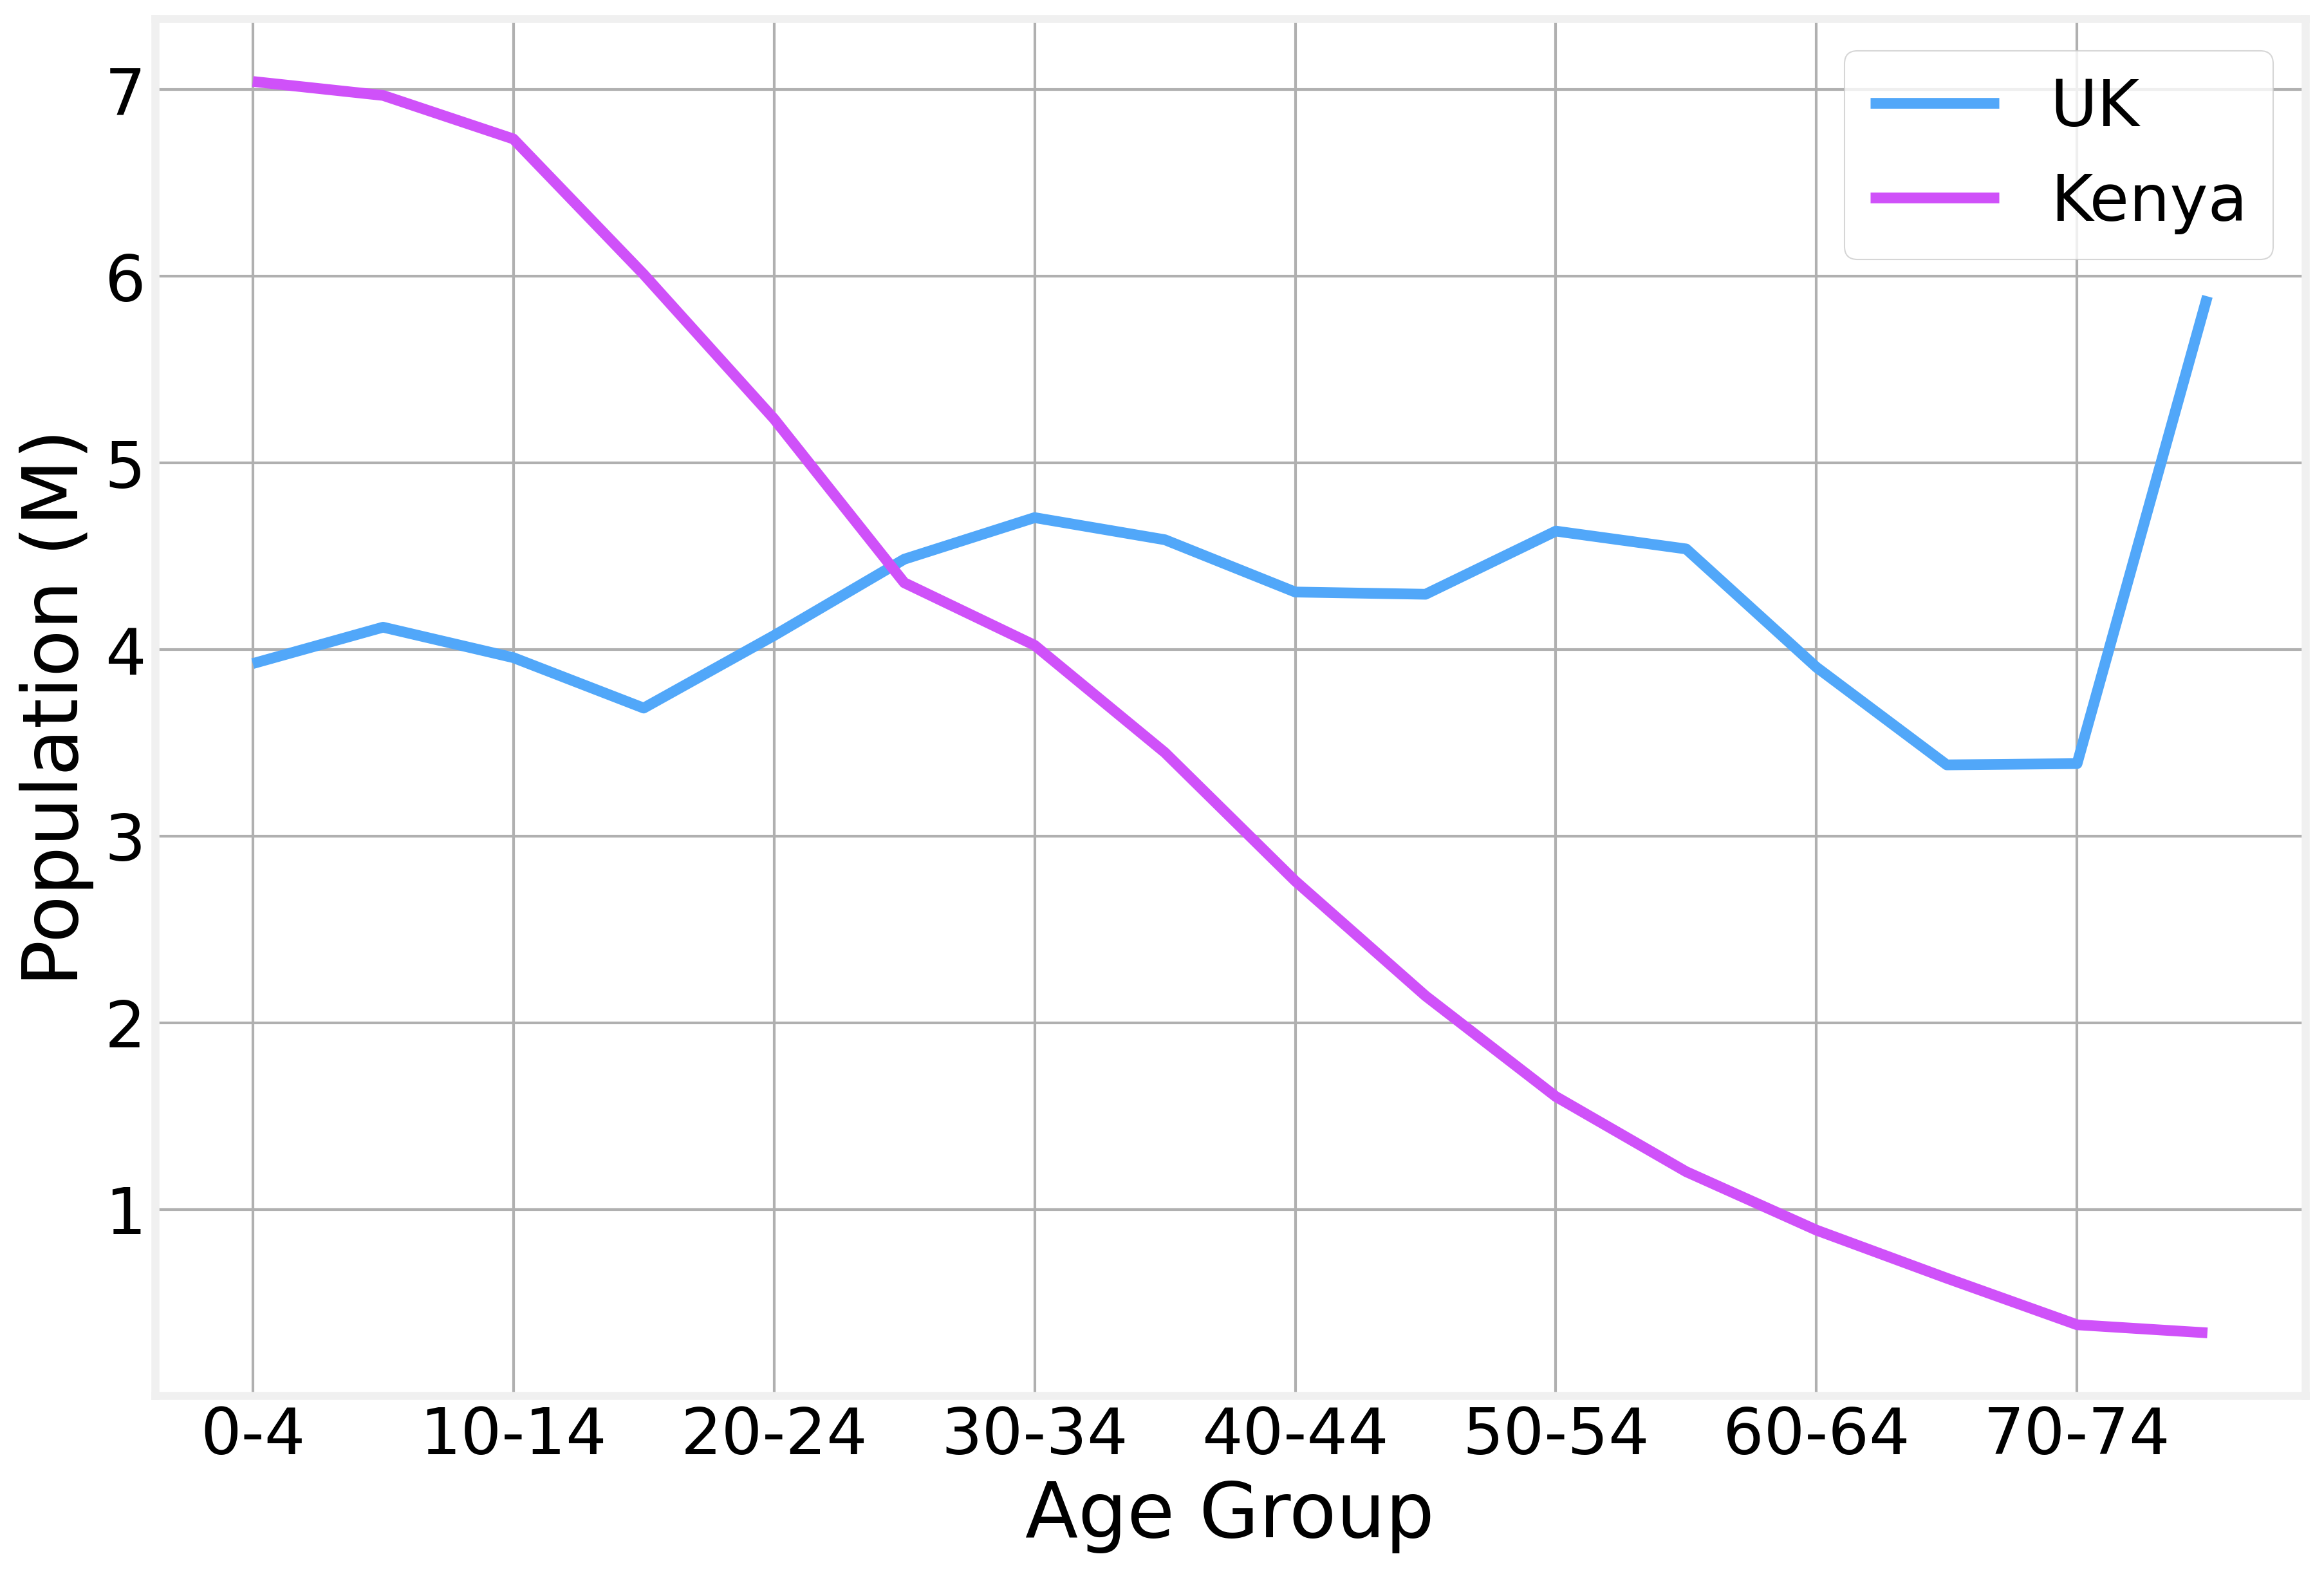

In [5]:
ax = (Nk_uk/1e6).plot()
(Nk_ke/1e6).plot(ax=ax)
ax.legend(['UK', 'Kenya'])
ax.set_xlabel('Age Group')
ax.set_ylabel('Population (M)')

despite having comparable total populations

In [6]:
N_uk = int(Nk_uk.sum())
N_ke = int(Nk_ke.sum())

print("Total UK population:", N_uk)
print("Total Kenya population:", N_ke)

Total UK population: 67886004
Total Kenya population: 53771299


## Contact matrix

Next we load the contact matrices for each country. Each element of the matrix indicates the number of contacts between each pair of age groups. 

In [7]:
contacts_ke = pd.read_excel("data/MUestimates_all_locations_1.xlsx", sheet_name="Kenya")
contacts_ke.index=Ages
contacts_ke.columns=Ages

contacts_uk = pd.read_excel("data/MUestimates_all_locations_2.xlsx", sheet_name="United Kingdom of Great Britain", header=None)
contacts_uk.index=Ages
contacts_uk.columns=Ages

The differences in population structure we observed above are reflected here. The younger Kenyan population has many more contacts between younger age groups (along the main diagonal), while the older UK population has more inter generational connections, as seen in the two diagonals parallel to the main one.

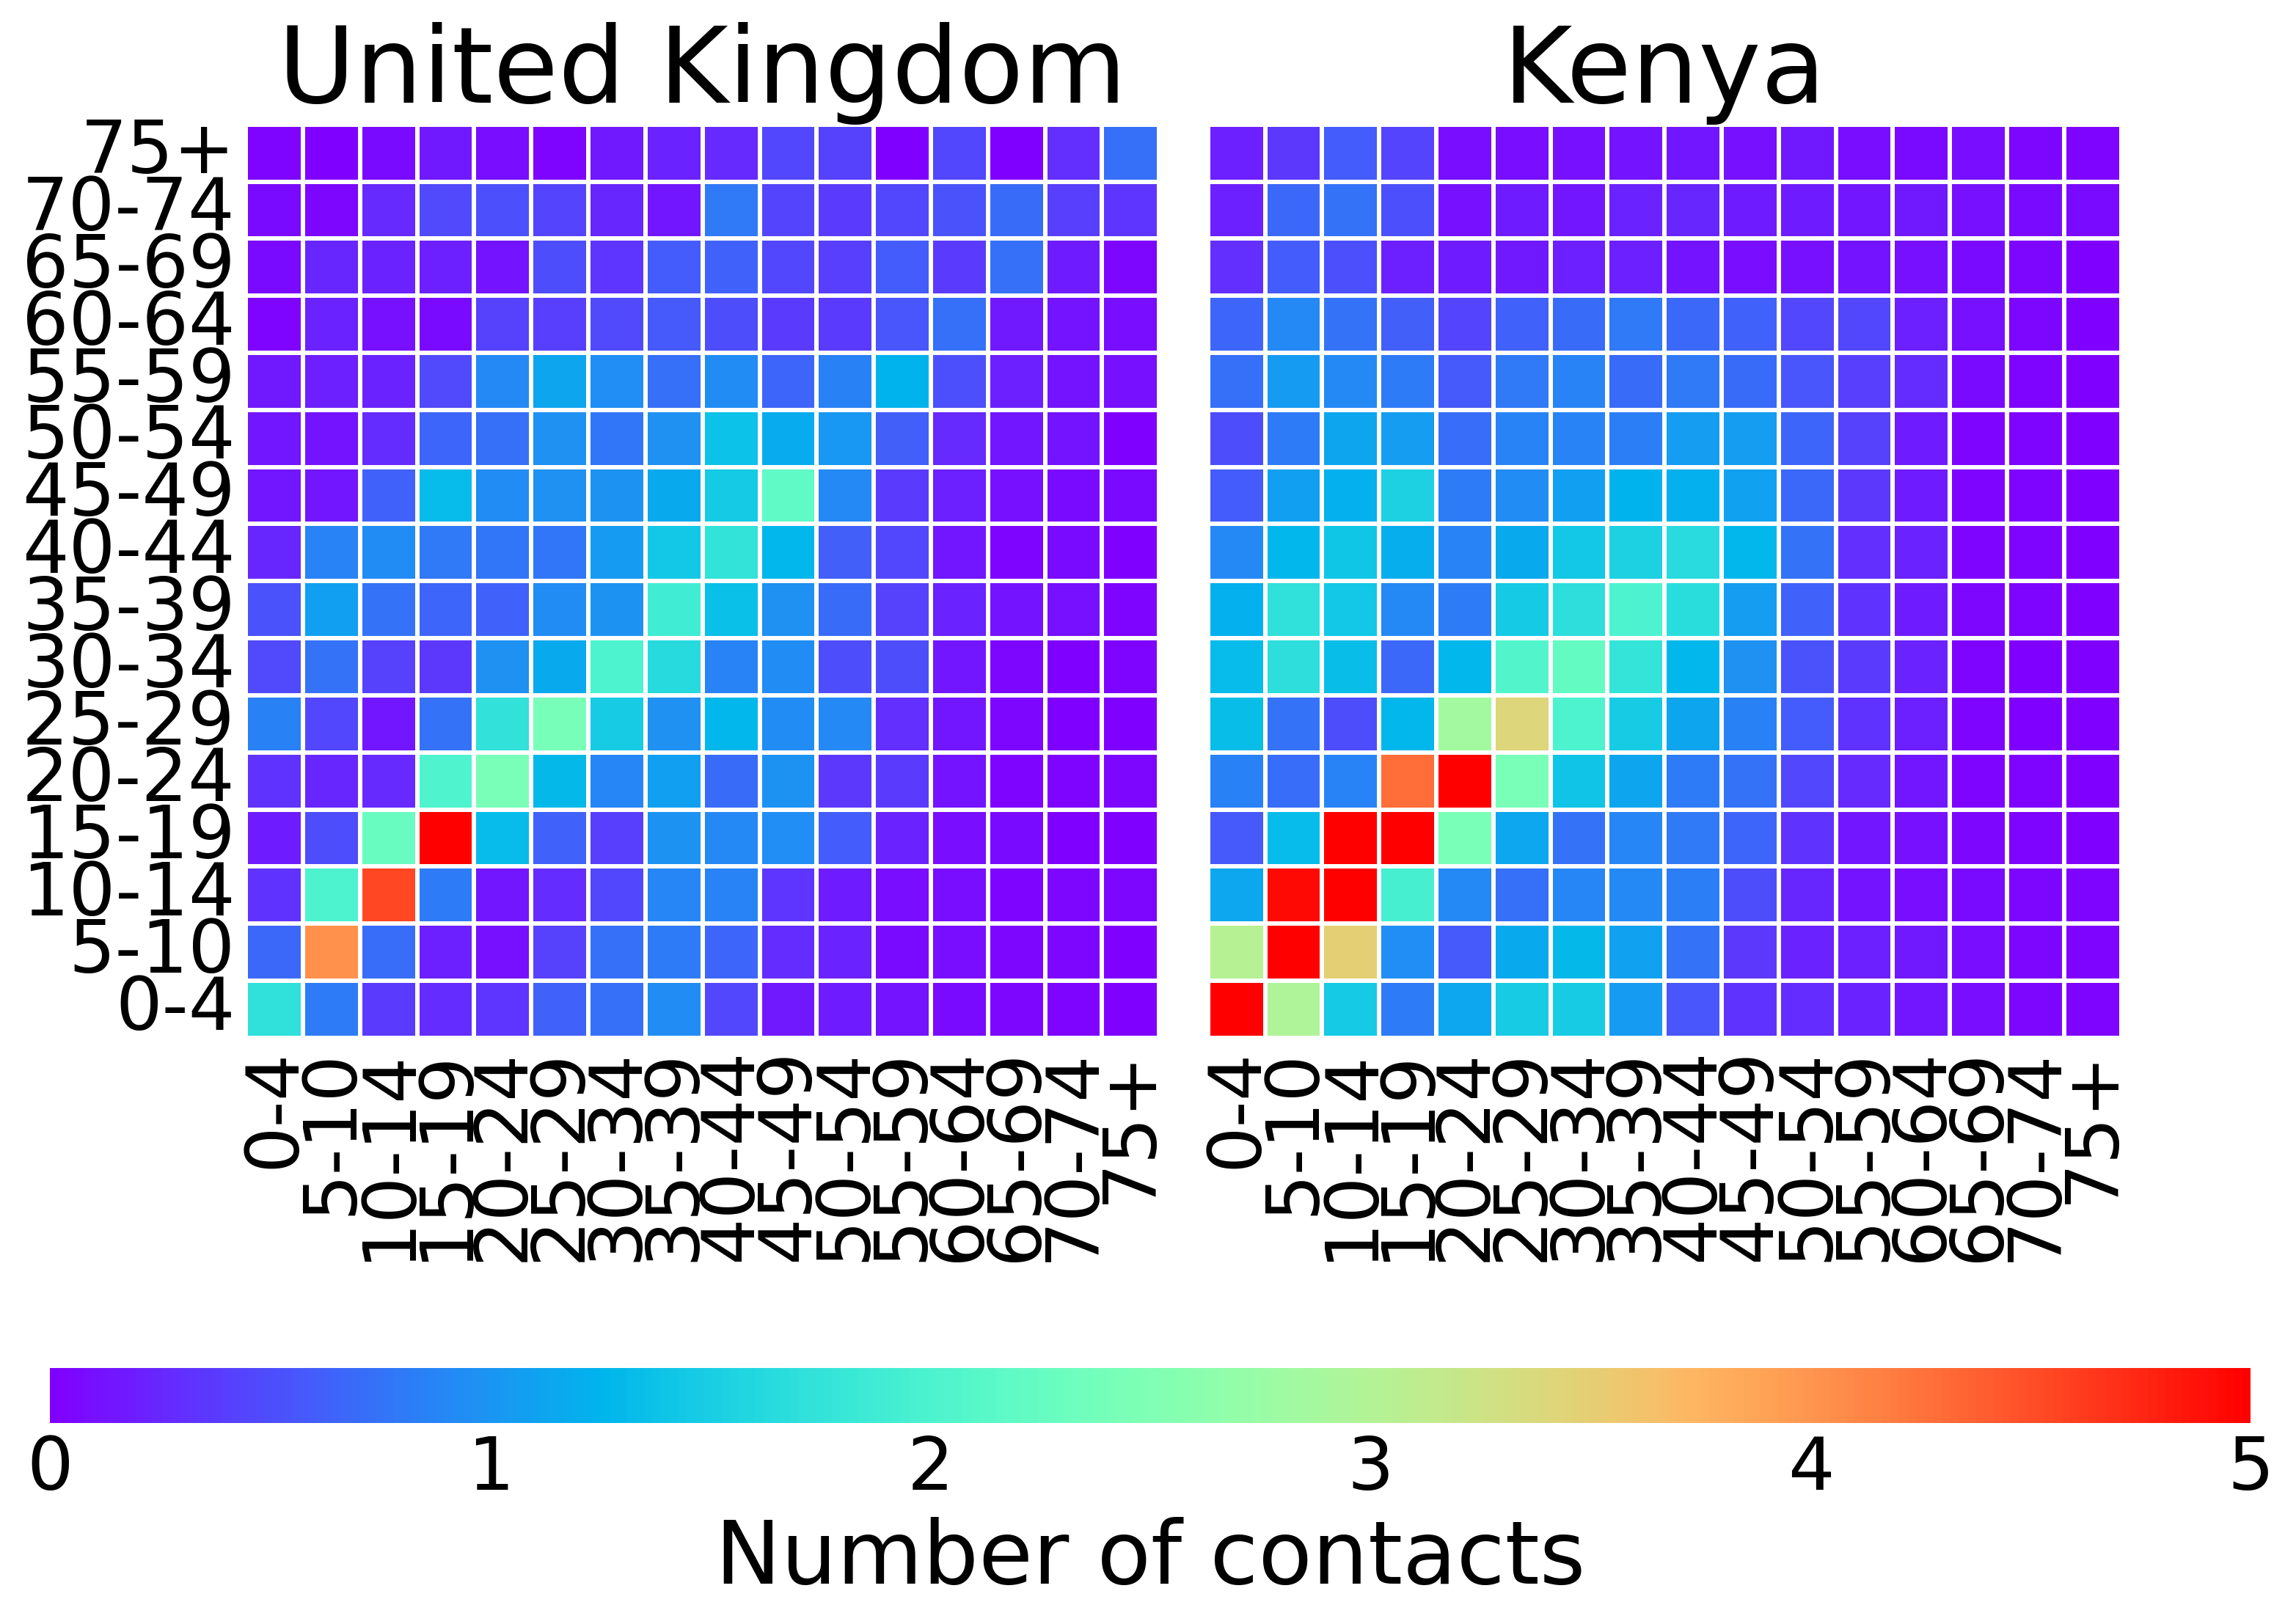

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0, -0.3, 1, 0.05])

sns.heatmap(contacts_uk[::-1], cmap=plt.cm.rainbow, ax=axs[0], vmin=0, vmax=5, 
            square=True, cbar=False, linewidth=1, linecolor='w',
            xticklabels=True, yticklabels=True)

sns.heatmap(contacts_ke[::-1], cmap=plt.cm.rainbow, ax=axs[1], vmin=0, vmax=5, 
            square=True, cbar_ax=cbar_ax, linewidth=1, linecolor='w',
            cbar_kws={'orientation':'horizontal', 
                      'label':'Number of contacts'},
            xticklabels=True, yticklabels=True)

axs[0].set_title('United Kingdom')
axs[1].set_title('Kenya')

fig.subplots_adjust(wspace=0.01)

# SIR Model with Age Structure

We start by setting up a regular SIR Model

In [9]:
beta = 0.05
mu = 0.1

SIR_uk = EpiModel()
SIR_uk.add_interaction('S', 'I', 'I', beta)
SIR_uk.add_spontaneous('I', 'R', mu)

With this choice of $\beta$ and $\mu$, the $R_0<1$ making an epidemic outbreak exponentially unlikely

In [10]:
print(SIR_uk)

Epidemic Model with 3 compartments and 2 transitions:

S + I = I 0.050000
I -> R 0.100000

R0=0.50


We can add the details of the age structure by providing both the contact matrix and the population of each age group

In [11]:
SIR_uk.add_age_structure(contacts_uk, Nk_uk)

This adds all the necessary compartments and transitions resulting in an increased value of $R_0$.

In [12]:
print(SIR_uk)

Epidemic Model with 48 compartments and 272 transitions:

S_a + I_a = I_a 0.085562
S_a + I_b = I_a 0.040168
S_a + I_c = I_a 0.019444
S_a + I_d = I_a 0.014286
S_a + I_e = I_a 0.016848
S_a + I_f = I_a 0.031434
S_a + I_g = I_a 0.036257
S_a + I_h = I_a 0.045943
S_a + I_i = I_a 0.022985
S_a + I_j = I_a 0.008732
S_a + I_k = I_a 0.009709
S_a + I_l = I_a 0.006577
S_a + I_m = I_a 0.003735
S_a + I_n = I_a 0.002168
S_a + I_o = I_a 0.001868
S_a + I_p = I_a 0.000360
I_a -> R_a 0.100000
S_b + I_a = I_b 0.034082
S_b + I_b = I_b 0.201713
S_b + I_c = I_b 0.035726
S_b + I_d = I_b 0.010478
S_b + I_e = I_b 0.005030
S_b + I_f = I_b 0.021318
S_b + I_g = I_b 0.036952
S_b + I_h = I_b 0.040776
S_b + I_i = I_b 0.032518
S_b + I_j = I_b 0.014509
S_b + I_k = I_b 0.011352
S_b + I_l = I_b 0.003651
S_b + I_m = I_b 0.004618
S_b + I_n = I_b 0.002902
S_b + I_o = I_b 0.001977
S_b + I_p = I_b 0.000674
I_b -> R_b 0.100000
S_c + I_a = I_c 0.015877
S_c + I_b = I_c 0.100439
S_c + I_c = I_c 0.227074
S_c + I_d = I_c 0.040877
S_

We can integrate the model as usual:

In [13]:
SIR_uk.integrate(100, S=N_ke*.99, I=N_ke*.01, R=0)

And by default, the `plot()` method, plots the totals for the original compartments

<Axes: title={'center': 'United Kingdom'}, xlabel='Time', ylabel='Population'>

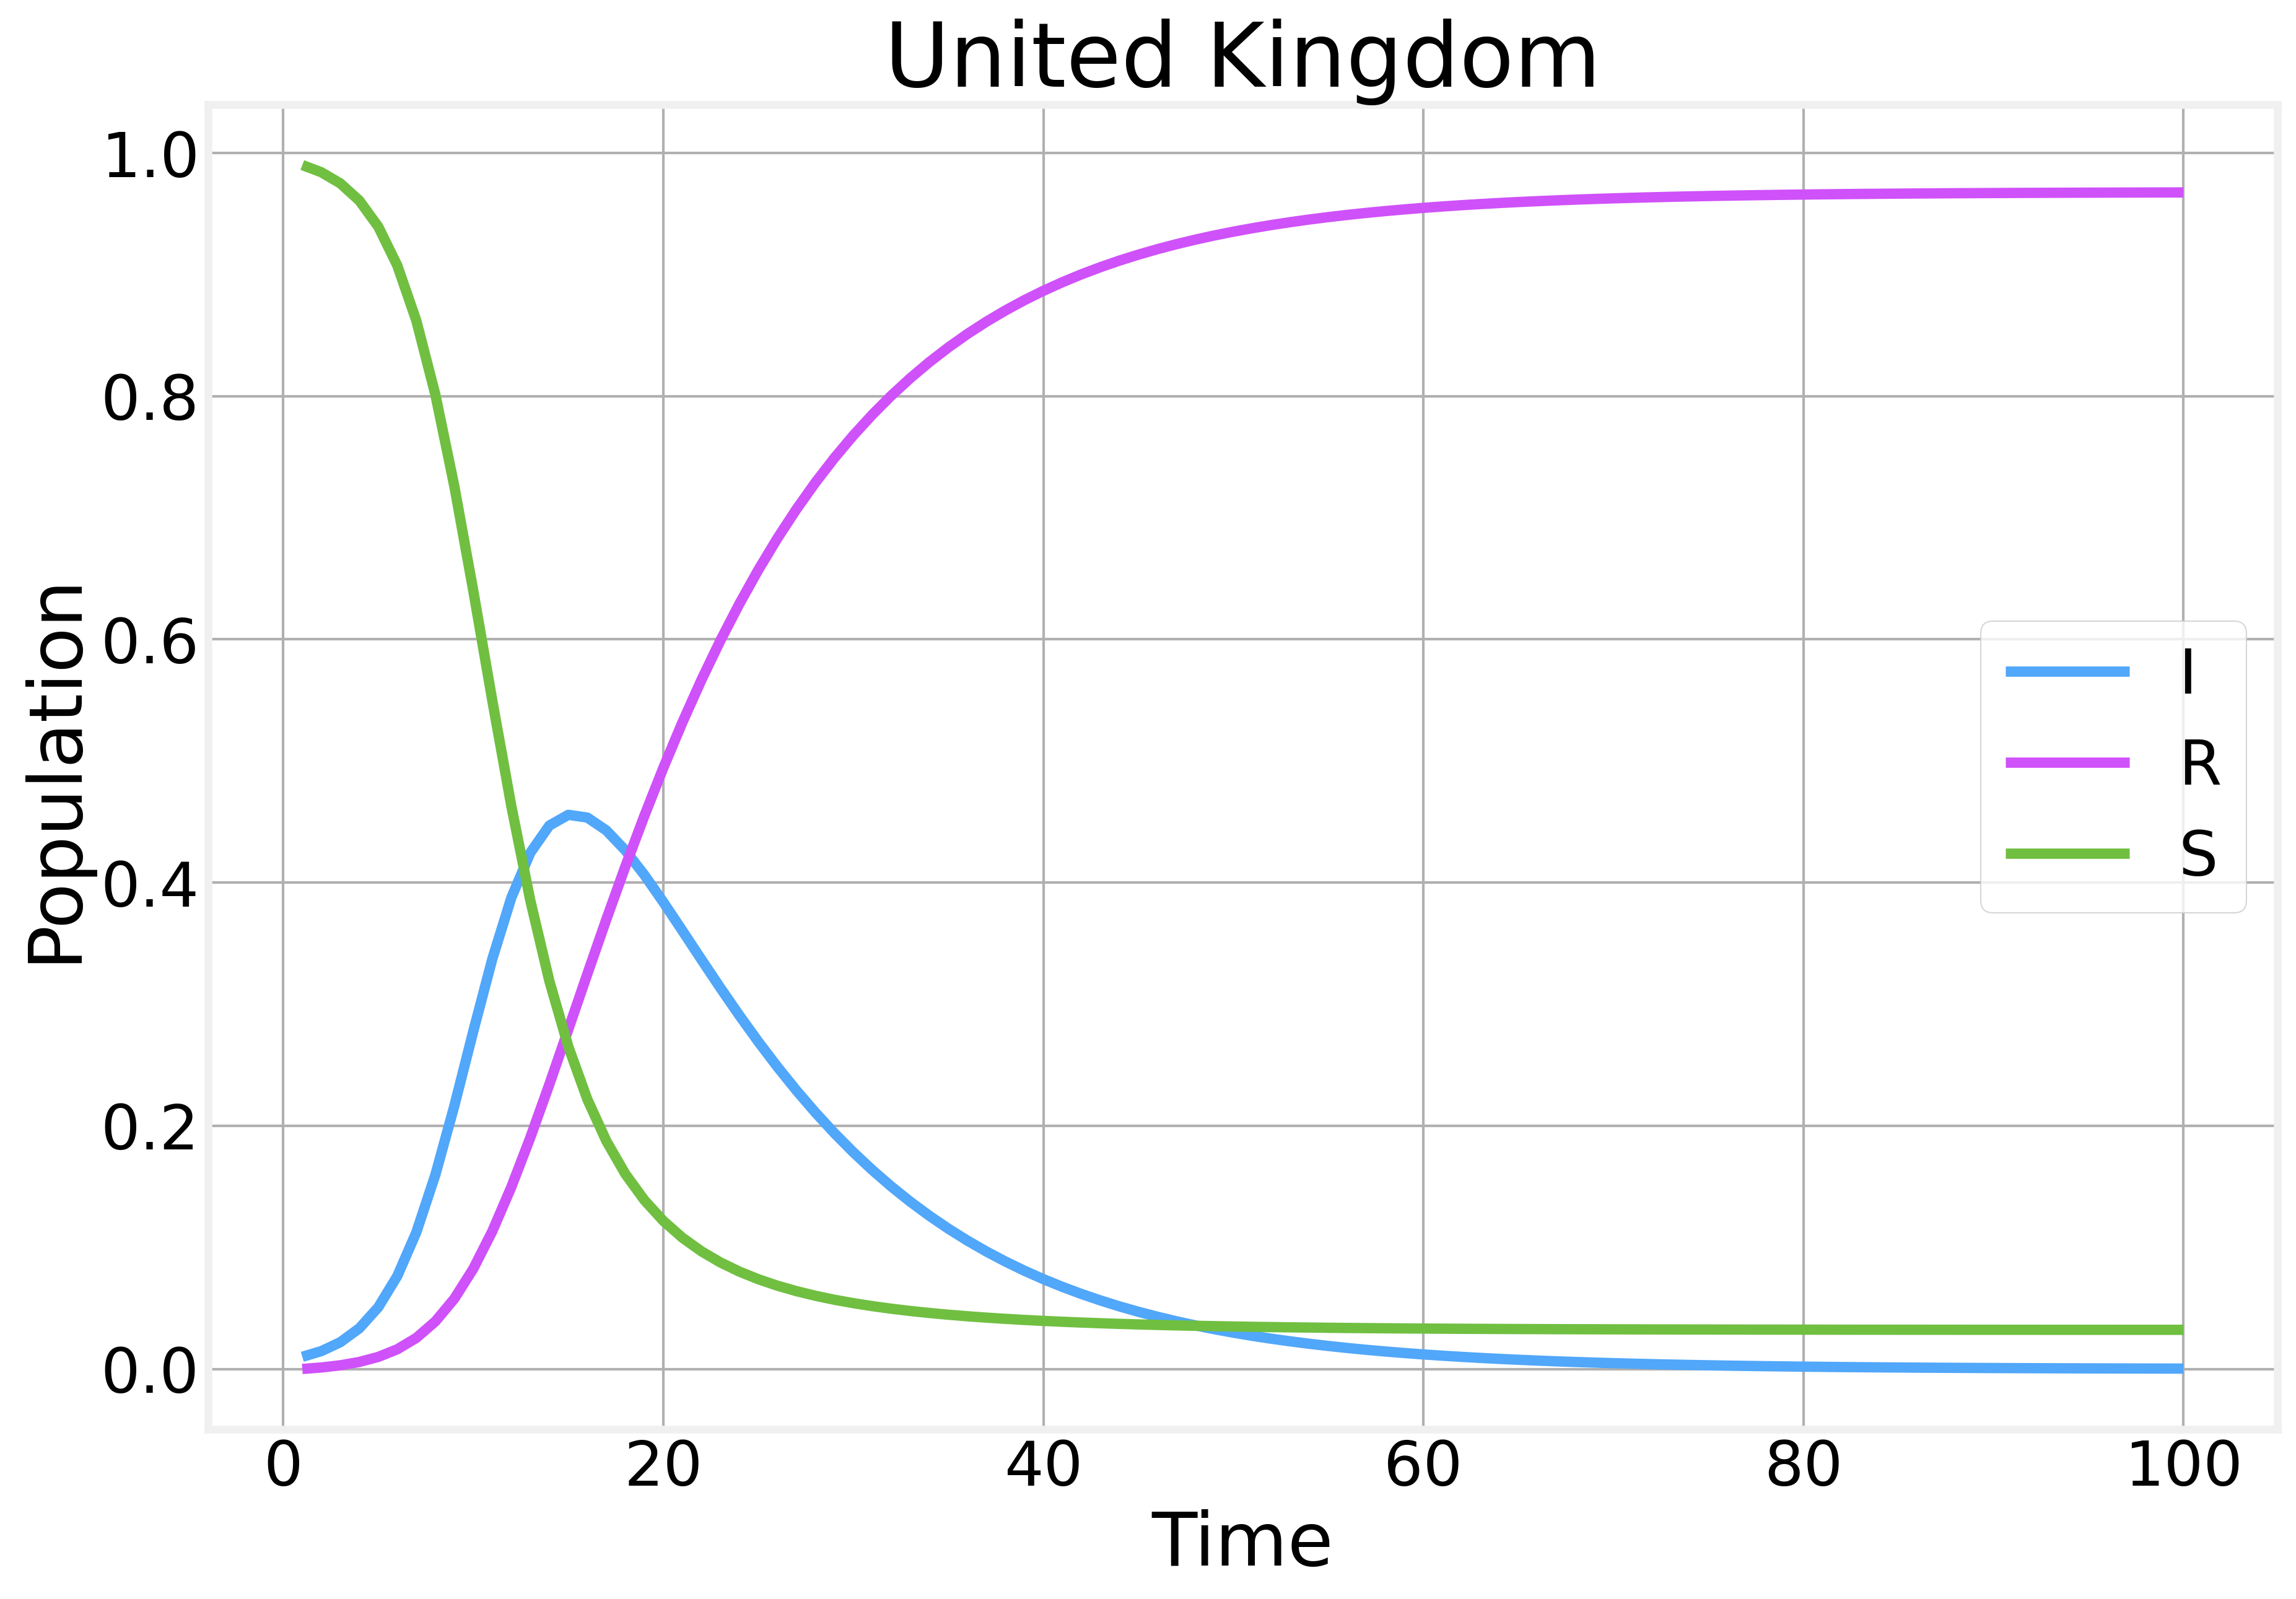

In [14]:
SIR_uk.plot(title='United Kingdom')

The values for each compartment are available in the `values_ages_` field

In [15]:
SIR_uk.values_ages_

,S_a,I_a,S_b,I_b,S_c,I_c,S_d,I_d,S_e,I_e,...,R_g,R_h,R_i,R_j,R_k,R_l,R_m,R_n,R_o,R_p
1,3.076666e+06,31311.000000,3.231416e+06,32575.000000,3.101687e+06,31302.000000,2.887584e+06,29273.000000,3.196077e+06,32339.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,3.063574e+06,40832.011892,3.213288e+06,46783.271176,3.080055e+06,48984.053430,2.854740e+06,57884.304778,3.173012e+06,51298.681490,...,4.675624e+03,4.579642e+03,4.318674e+03,4.340554e+03,4.461989e+03,4.386765e+03,3.383378e+03,2.955040e+03,3.029521e+03,4.853110e+03
3,3.043905e+06,55727.210426,3.186267e+06,68130.354329,3.046623e+06,76250.916815,2.799163e+06,105487.339018,3.135888e+06,81883.081954,...,1.188502e+04,1.177928e+04,1.108565e+04,1.130111e+04,1.108328e+04,1.083759e+04,7.587052e+03,6.720860e+03,6.953510e+03,1.032353e+04
4,3.014173e+06,78815.479580,3.145846e+06,100241.402682,2.995344e+06,117964.664218,2.708795e+06,181778.611972,3.077115e+06,130230.061609,...,2.299004e+04,2.299007e+04,2.164741e+04,2.236376e+04,2.108451e+04,2.047281e+04,1.310379e+04,1.177058e+04,1.228276e+04,1.684283e+04
5,2.969362e+06,114101.872627,3.085619e+06,148204.075978,2.917821e+06,180759.060675,2.568361e+06,298582.284775,2.986280e+06,204580.307852,...,4.002050e+04,4.028567e+04,3.800973e+04,3.973913e+04,3.629771e+04,3.497888e+04,2.067979e+04,1.882090e+04,1.979831e+04,2.507135e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.012982e+05,1618.946012,3.474185e+04,1189.265631,1.243272e+04,856.897350,6.049073e+02,518.857125,1.217895e+04,831.056211,...,3.709899e+06,3.618100e+06,3.400054e+06,3.391283e+06,3.638270e+06,3.559331e+06,2.854131e+06,2.517298e+06,2.553700e+06,3.748744e+06
97,1.012865e+05,1476.015893,3.473670e+04,1080.989684,1.243075e+04,777.230162,6.047910e+02,469.591917,1.217718e+04,753.650702,...,3.710000e+06,3.618193e+06,3.400141e+06,3.391365e+06,3.638385e+06,3.559448e+06,2.854348e+06,2.517470e+06,2.553866e+06,3.749289e+06
98,1.012759e+05,1345.676673,3.473202e+04,982.570419,1.242895e+04,704.971464,6.046855e+02,425.004586,1.217558e+04,683.455951,...,3.710091e+06,3.618277e+06,3.400220e+06,3.391439e+06,3.638490e+06,3.559555e+06,2.854547e+06,2.517626e+06,2.554018e+06,3.749789e+06
99,1.012662e+05,1226.822006,3.472777e+04,893.110727,1.242733e+04,639.432187,6.045899e+02,384.650940,1.217412e+04,619.800154,...,3.710173e+06,3.618353e+06,3.400292e+06,3.391506e+06,3.638585e+06,3.559651e+06,2.854729e+06,2.517769e+06,2.554156e+06,3.750249e+06


So we can also visualize the number of infected in each age group:

In [16]:
infected_compartments = [col for col in SIR_uk.values_ages_.columns if col[0]=='I']

Text(0.5, 1.0, 'United Kingdom')

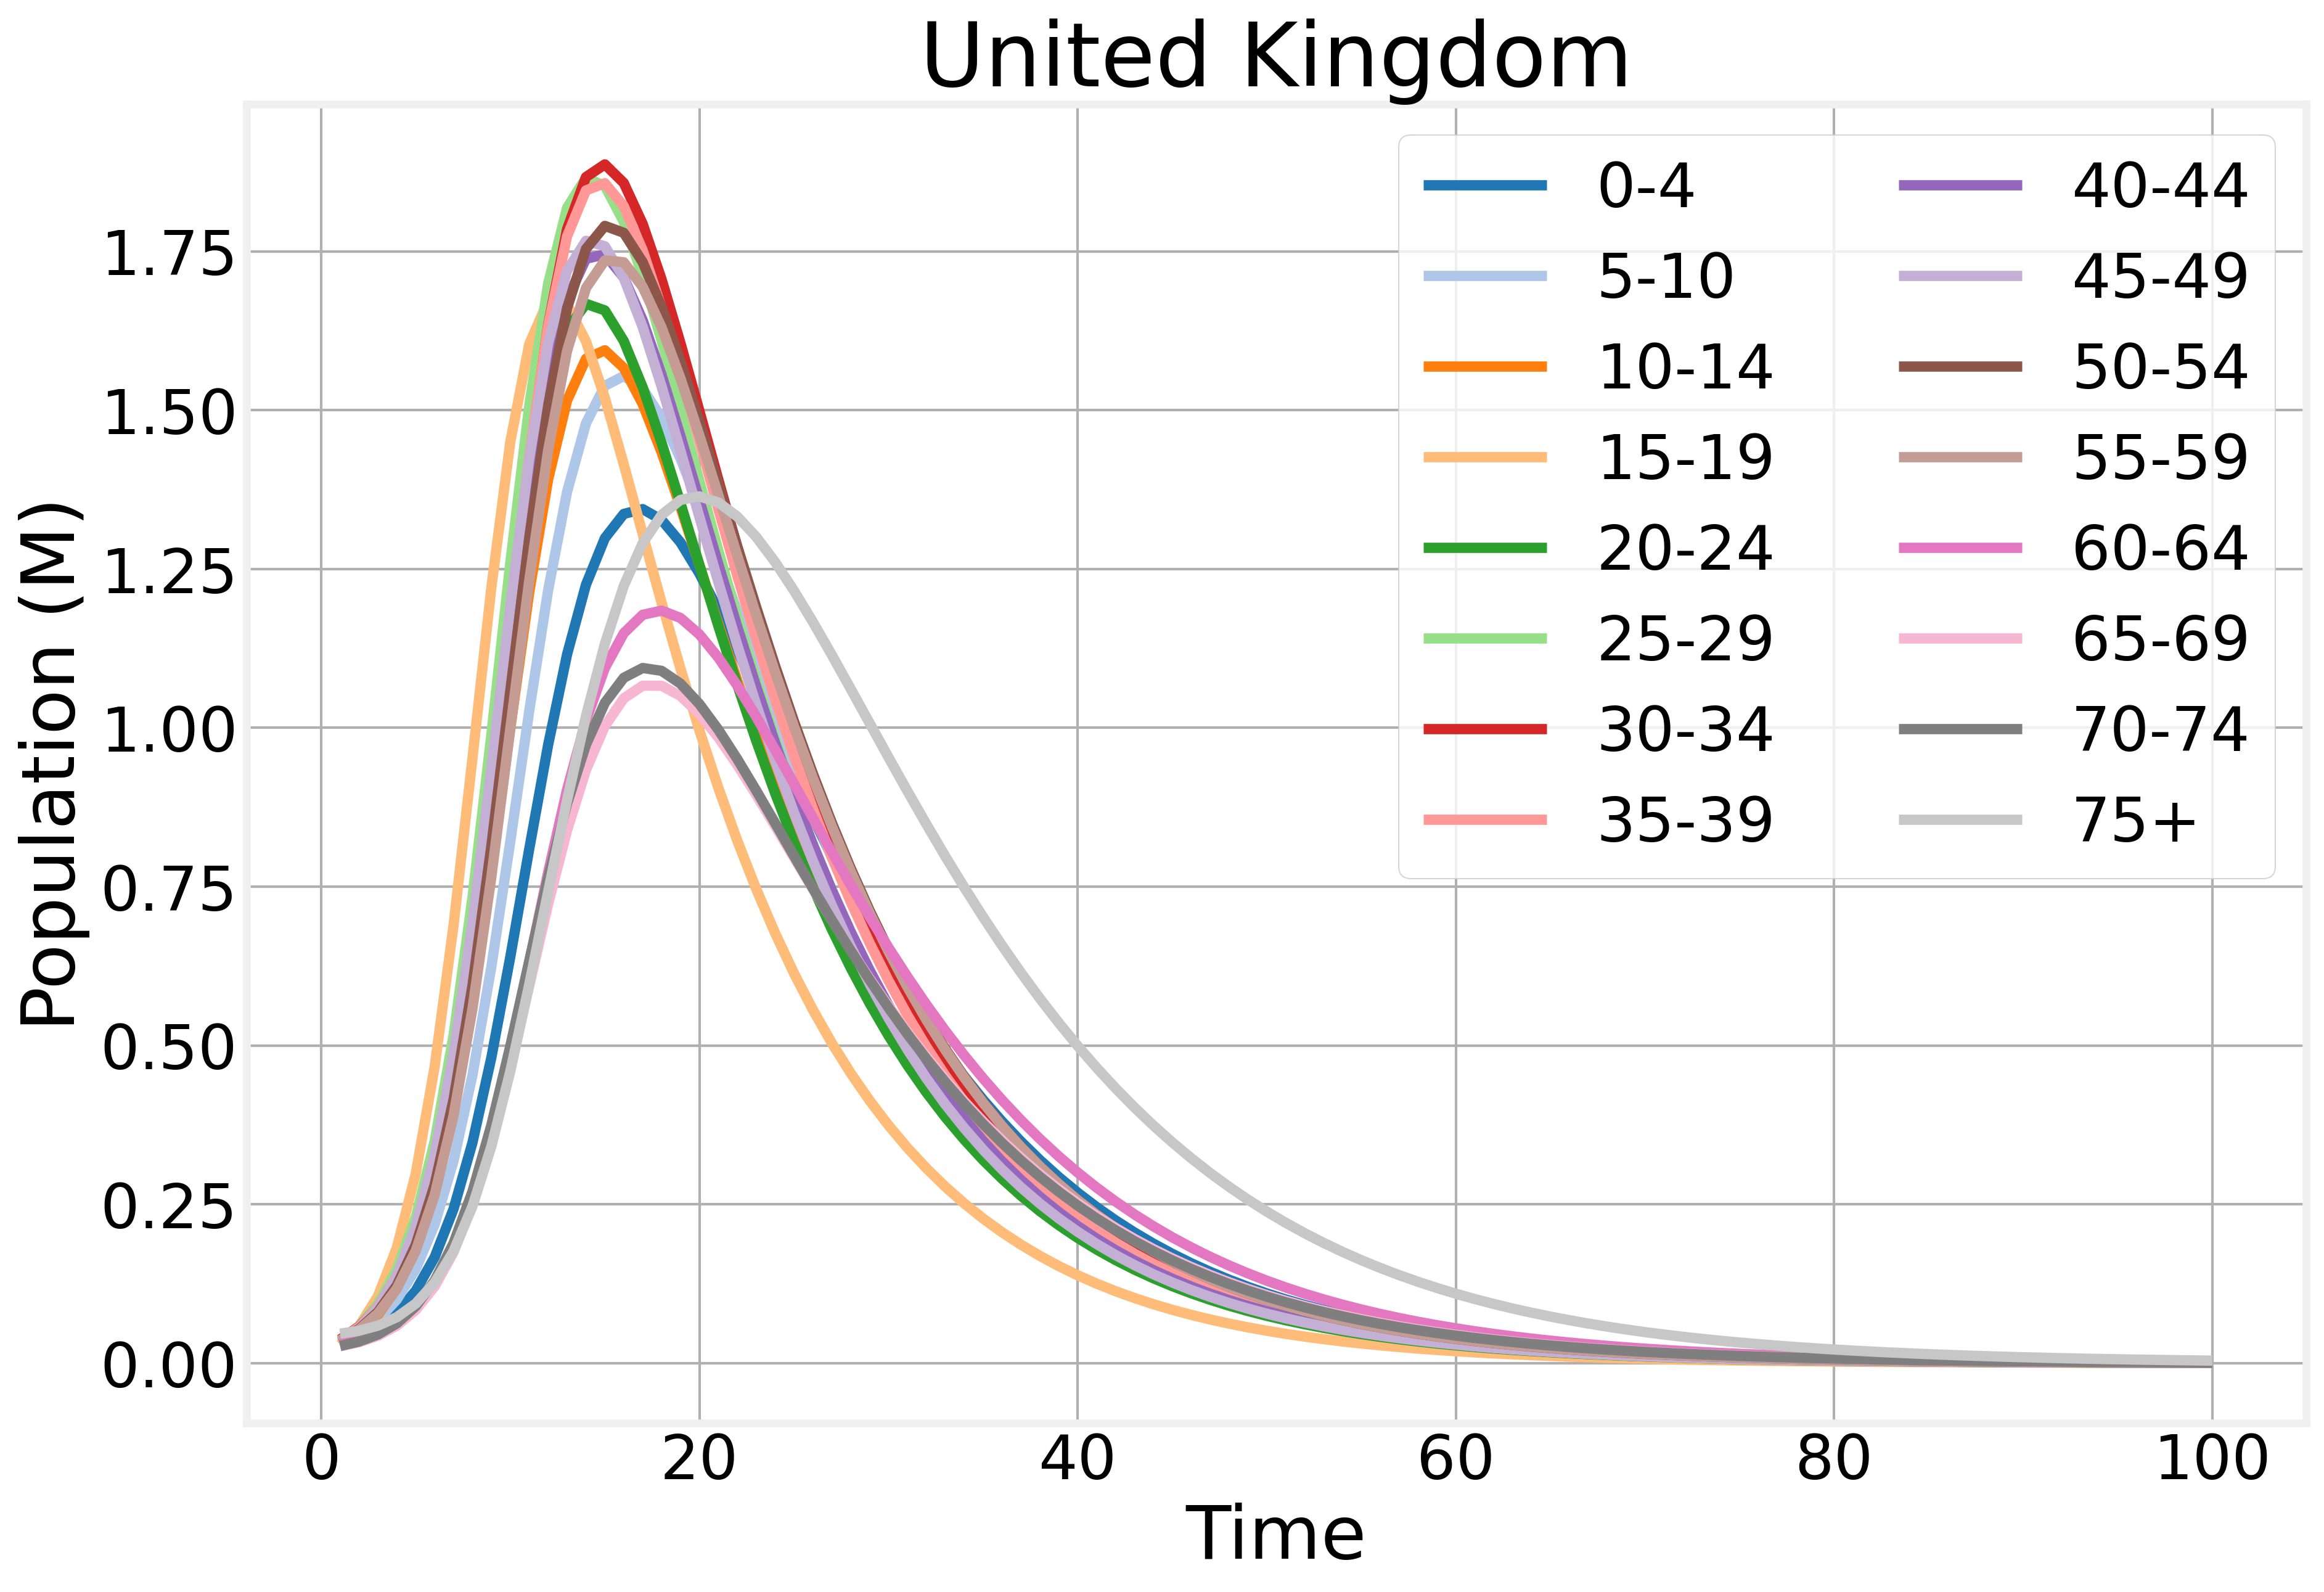

In [17]:
fig, ax = plt.subplots(1)
(SIR_uk.values_ages_[infected_compartments]/1e6).plot(ax=ax, color=plt.cm.tab20(np.arange(16)))
ax.legend(Ages, loc='upper right', ncols=2)
ax.set_xlabel('Time')
ax.set_ylabel('Population (M)')
ax.set_title('United Kingdom')

# Impact of the Age Structure

Let us define a similar SIR model for Kenya

In [18]:
SIR_ke = EpiModel()
SIR_ke.add_interaction('S', 'I', 'I', beta)
SIR_ke.add_spontaneous('I', 'R', mu)

And add the age structure

In [19]:
SIR_ke.add_age_structure(contacts_ke, Nk_ke)
print(SIR_ke)

Epidemic Model with 48 compartments and 272 transitions:

S_a + I_a = I_a 0.288341
S_a + I_b = I_a 0.147539
S_a + I_c = I_a 0.072600
S_a + I_d = I_a 0.040842
S_a + I_e = I_a 0.056683
S_a + I_f = I_a 0.073993
S_a + I_g = I_a 0.073985
S_a + I_h = I_a 0.051981
S_a + I_i = I_a 0.027353
S_a + I_j = I_a 0.016339
S_a + I_k = I_a 0.014310
S_a + I_l = I_a 0.010910
S_a + I_m = I_a 0.006902
S_a + I_n = I_a 0.004652
S_a + I_o = I_a 0.002810
S_a + I_p = I_a 0.001219
I_a -> R_a 0.100000
S_b + I_a = I_b 0.152109
S_b + I_b = I_b 0.665285
S_b + I_c = I_b 0.174688
S_b + I_d = I_b 0.047337
S_b + I_e = I_b 0.029271
S_b + I_f = I_b 0.058048
S_b + I_g = I_b 0.065197
S_b + I_h = I_b 0.055112
S_b + I_i = I_b 0.037314
S_b + I_j = I_b 0.018499
S_b + I_k = I_b 0.011477
S_b + I_l = I_b 0.009978
S_b + I_m = I_b 0.008353
S_b + I_n = I_b 0.004636
S_b + I_o = I_b 0.002234
S_b + I_p = I_b 0.001298
I_b -> R_b 0.100000
S_c + I_a = I_c 0.056846
S_c + I_b = I_c 0.246503
S_c + I_c = I_c 0.750994
S_c + I_d = I_c 0.096810
S_

And integrate it, using similar parameters as for the UK

In [20]:
SIR_ke.integrate(100, S=N_ke*.99, I=N_ke*.01, R=0)

<Axes: title={'center': 'Kenya'}, xlabel='Time', ylabel='Population'>

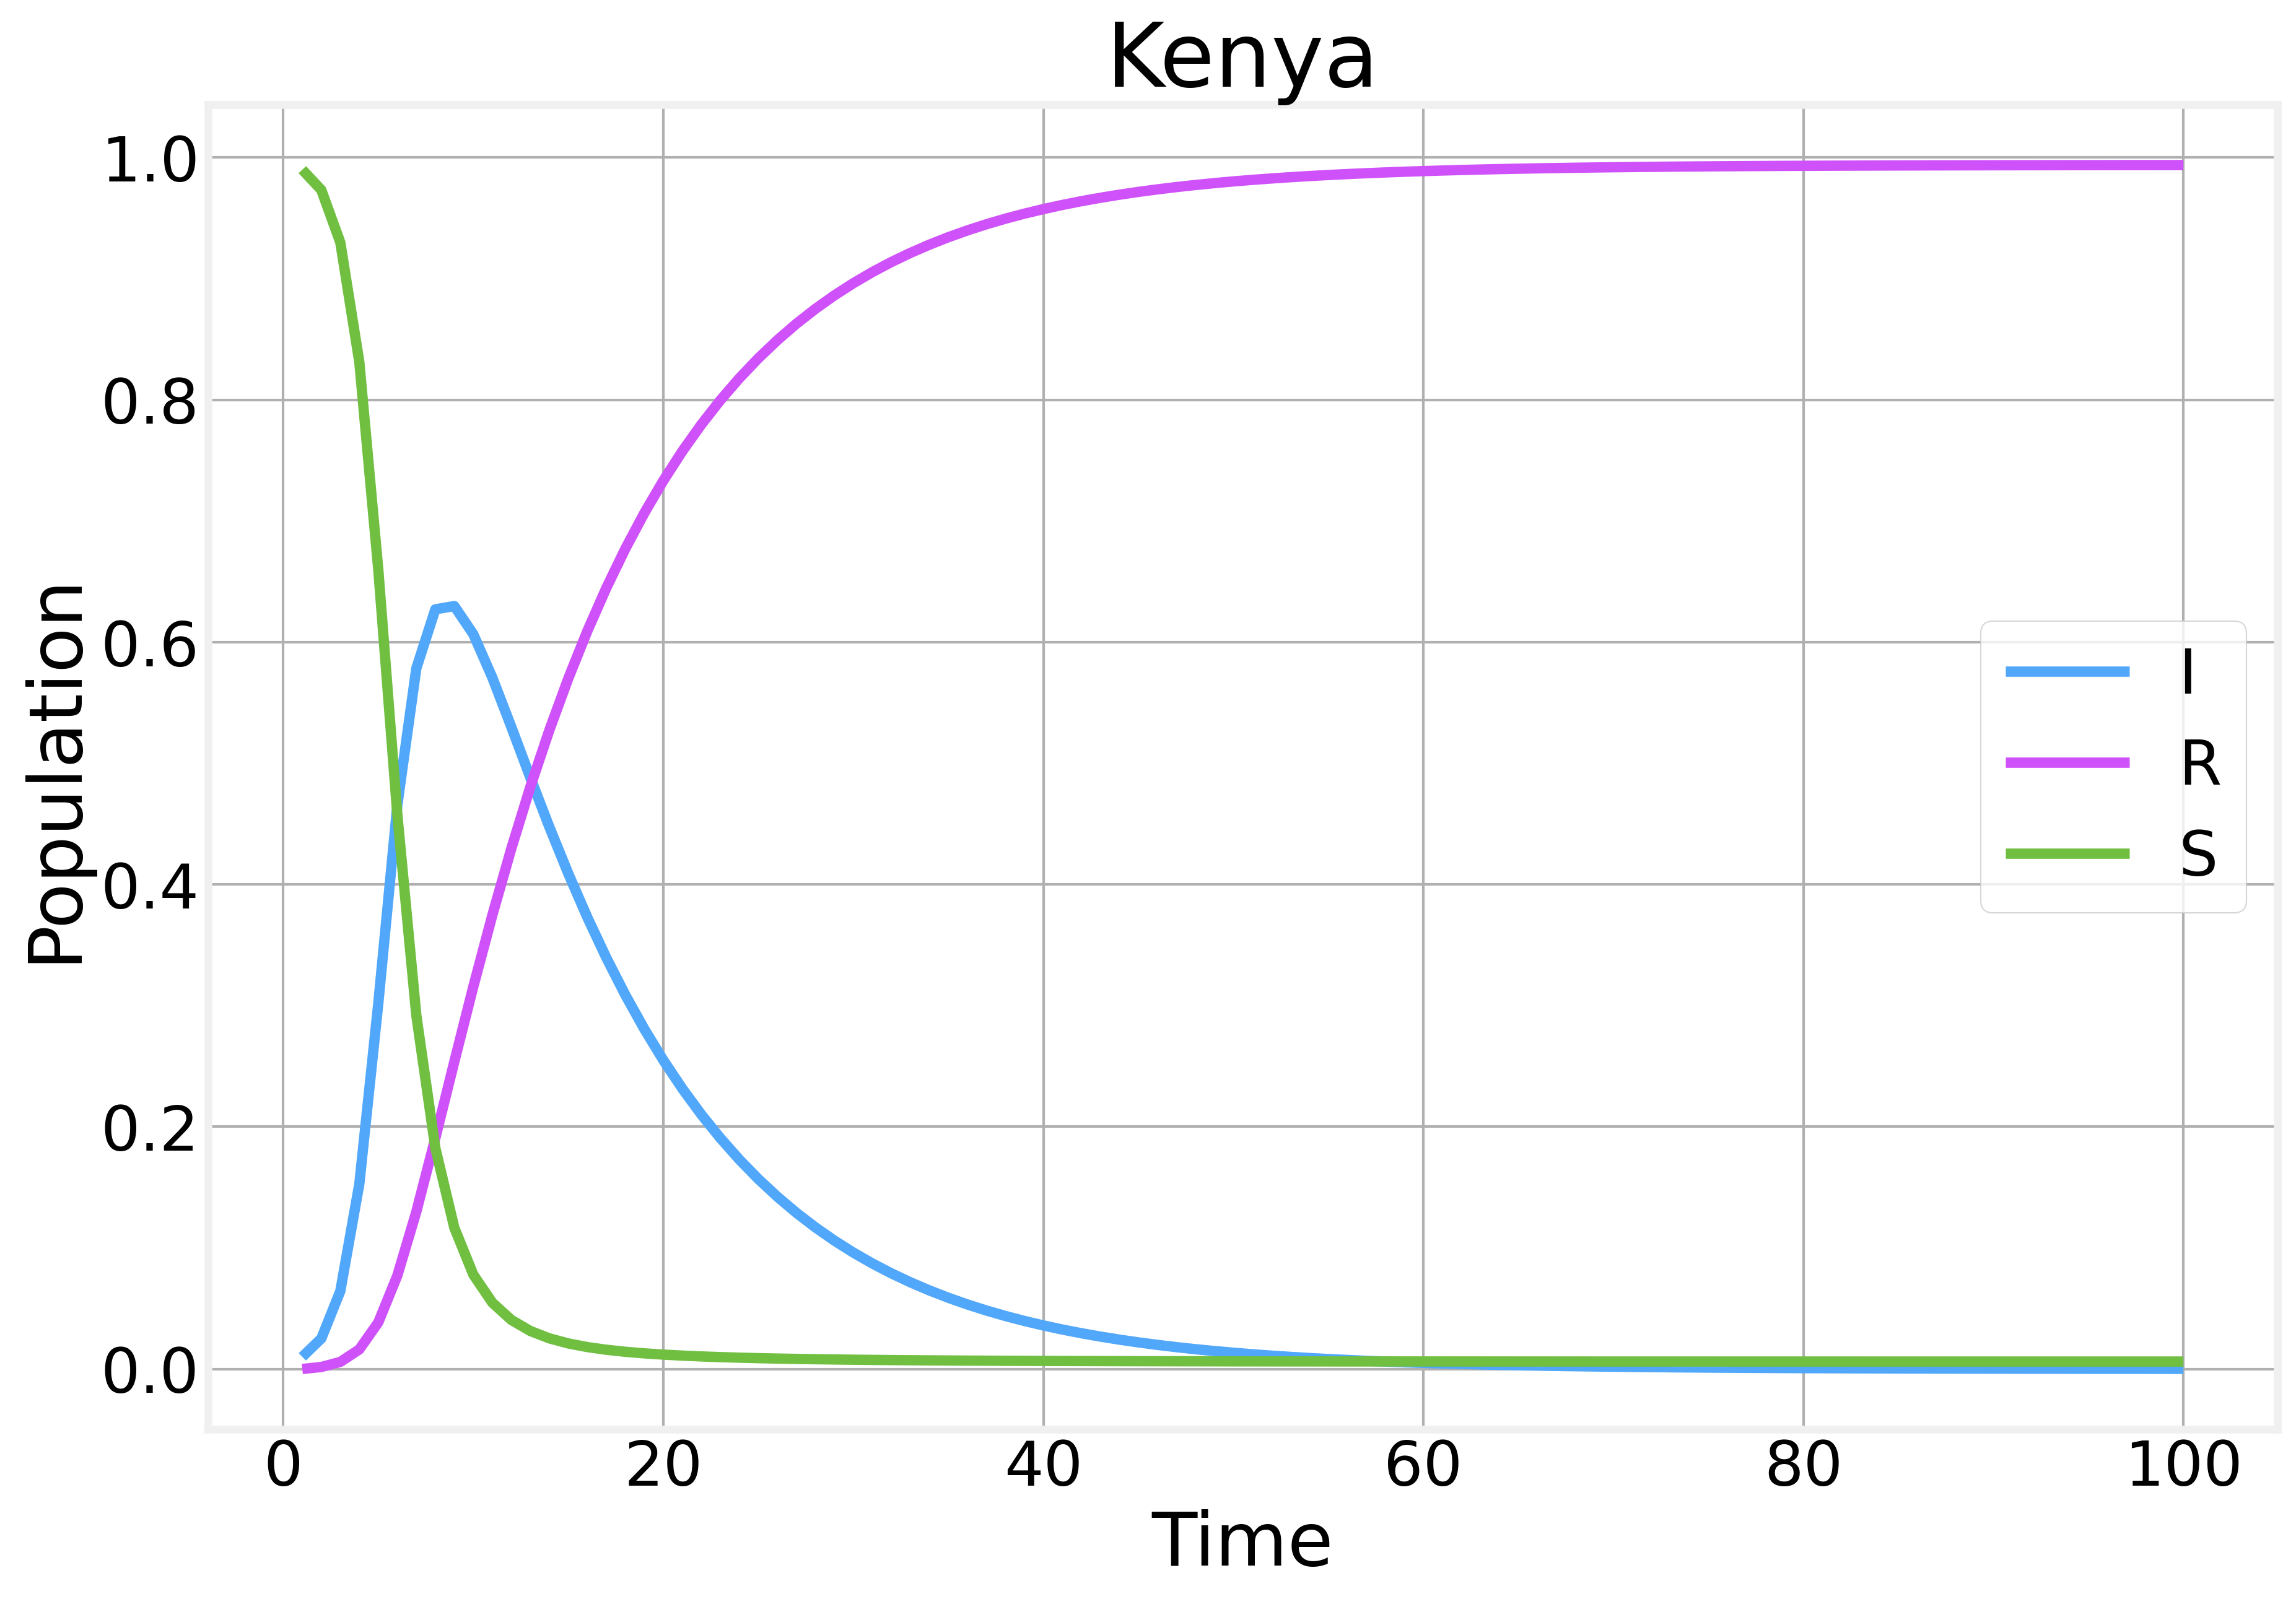

In [21]:
SIR_ke.plot(title='Kenya')

Text(0, 0.5, 'Population (%)')

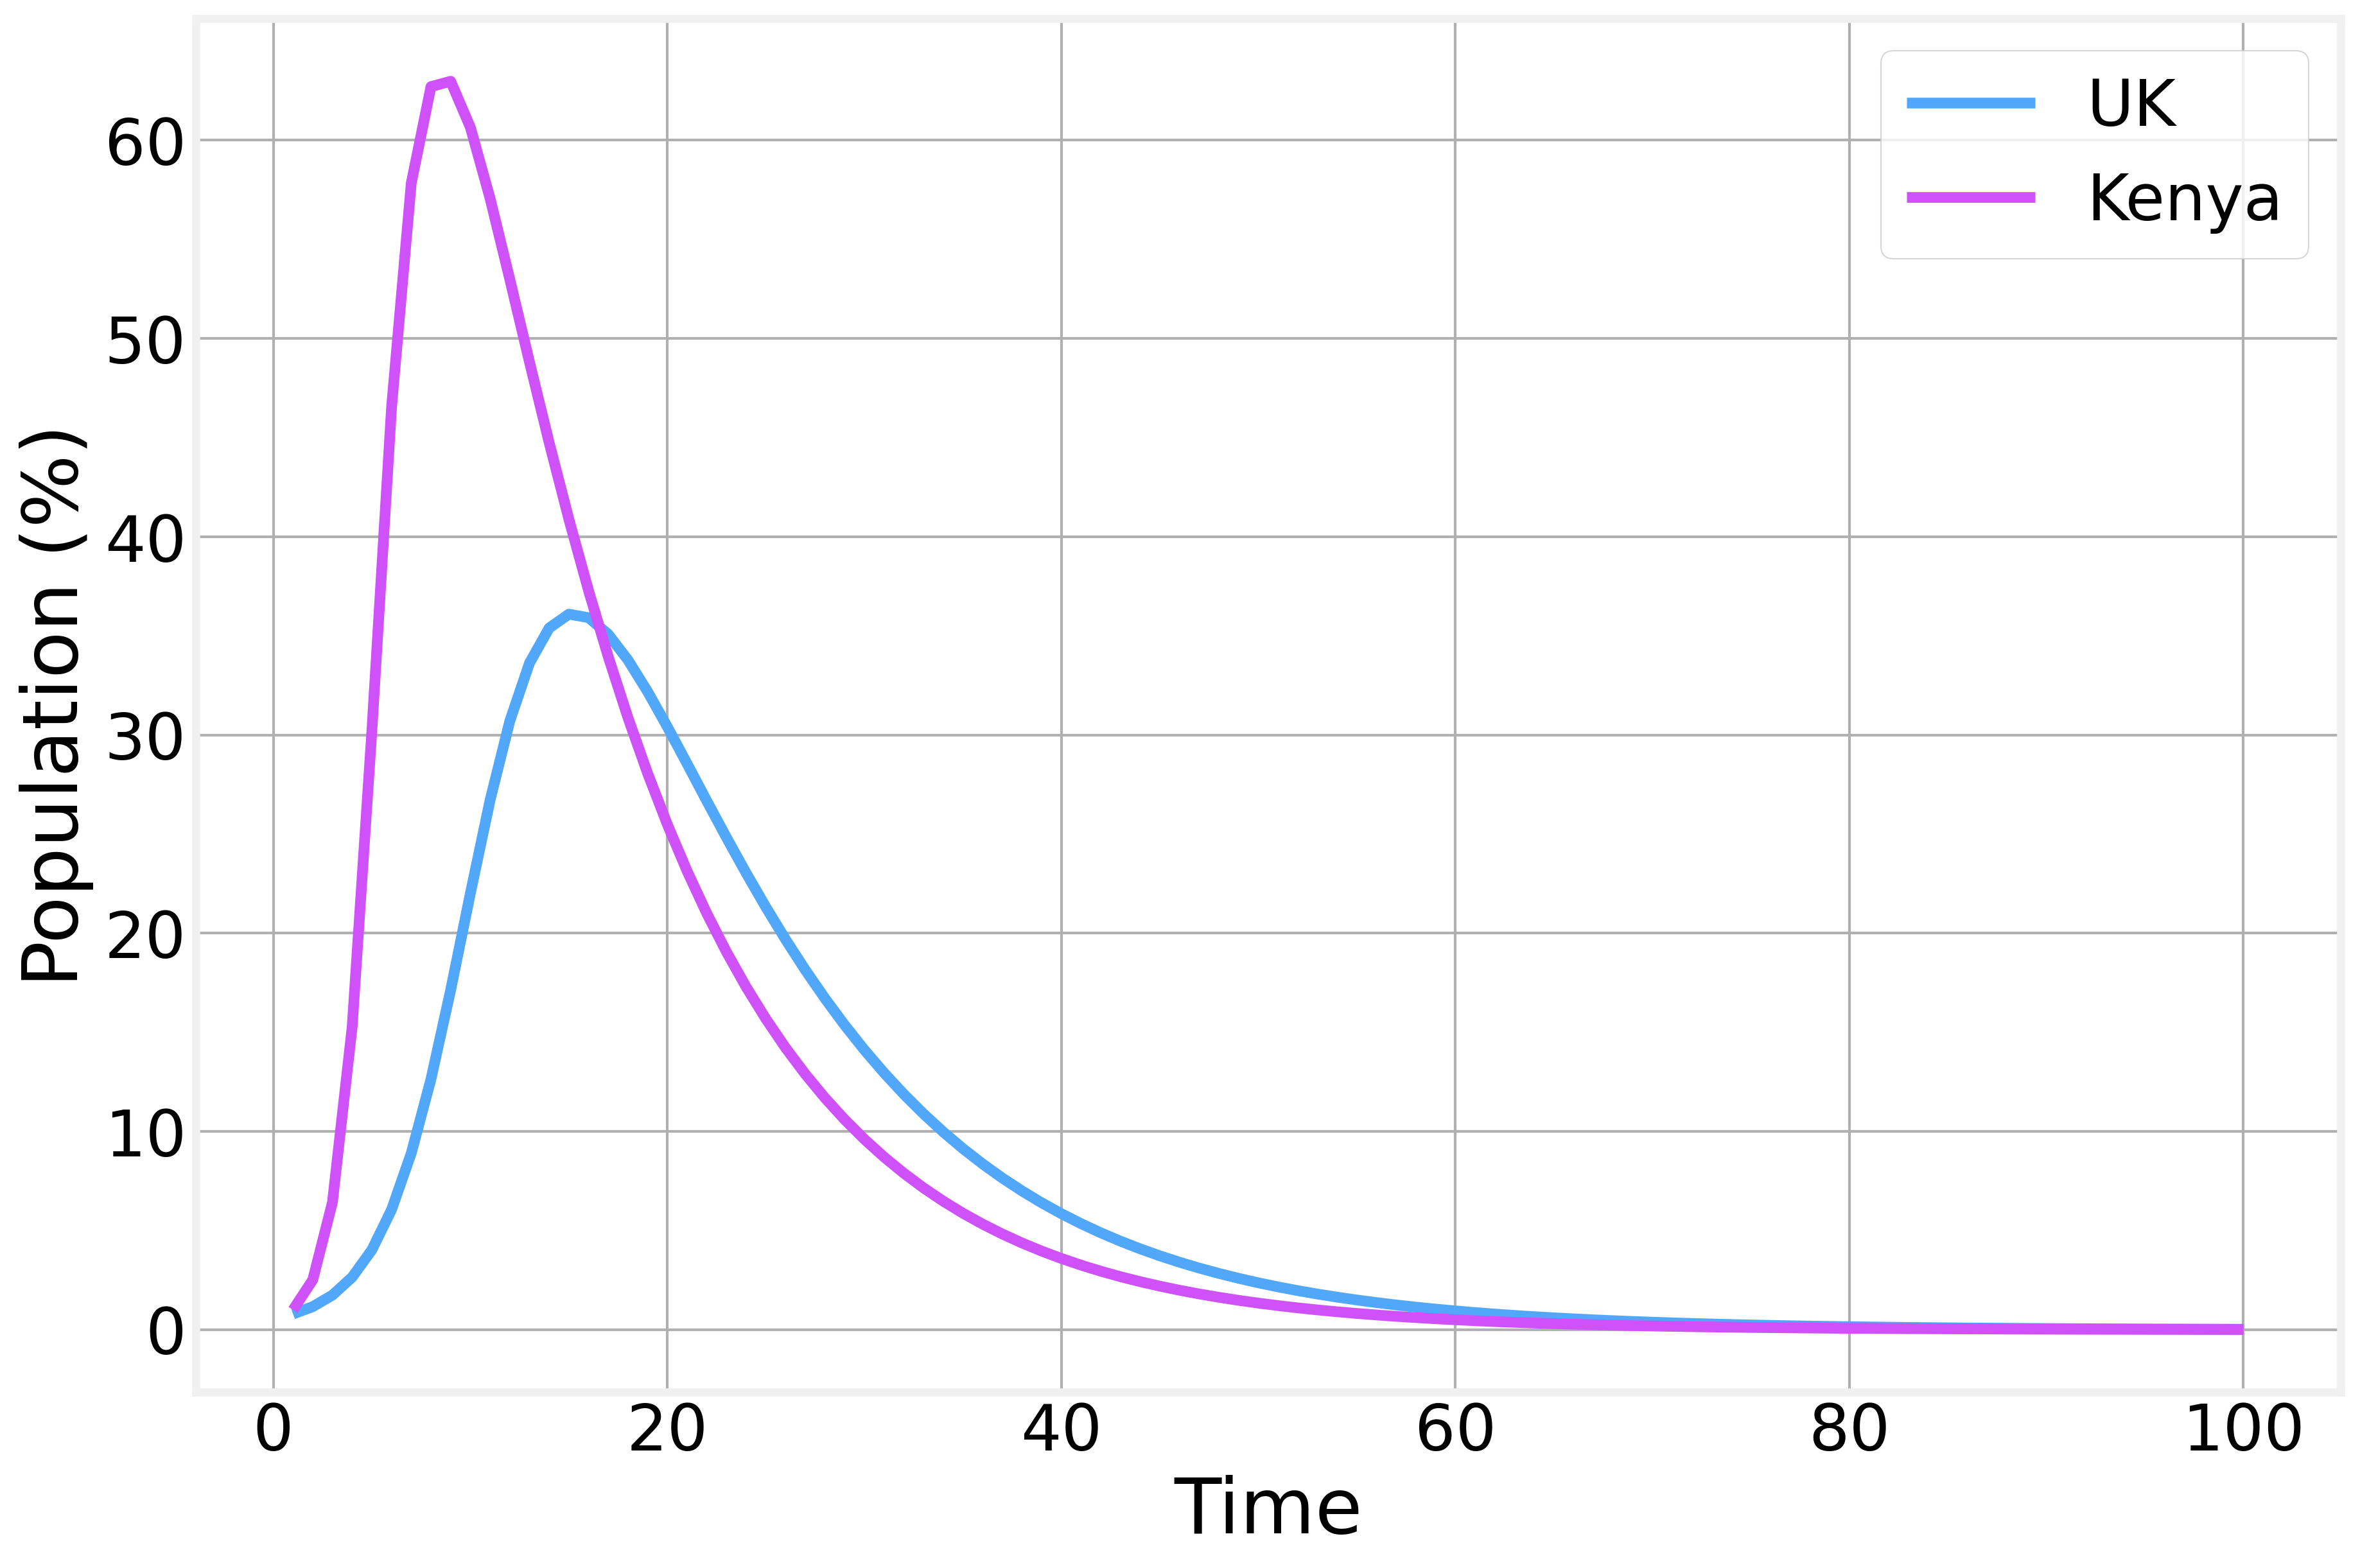

In [22]:
fig, ax = plt.subplots(1)

(SIR_uk['I']*100/N_uk).plot(ax=ax)
(SIR_ke['I']*100/N_ke).plot(ax=ax)
ax.legend(['UK', 'Kenya'])
ax.set_xlabel('Time')
ax.set_ylabel('Population (%)')

<center>
     <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>